In [1]:
import pandas
import tensorflow
import keras
import sklearn
import matplotlib.pyplot as plt
import ast
import inspect
import types
import json
from contextlib import suppress
from _ast import AST
from ast import parse
import codecs
import pandas as pd
import asttokens
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [2]:
# First we iterate over all the modules that are not built in
# and find the globals that are modules and for each of those we parse the ast of the module.

parsed_modules_asts ={
    x : ast.parse(inspect.getsource(y))
    for x,y in globals().items()
    if isinstance(y, types.ModuleType)
    and x not in  ('__builtins__',
                   '__builtin__',
                  )
         
}


In [3]:
# lifted from ast-to-json

BUILTIN_PURE = (int, float, bool)
BUILTIN_BYTES = (bytearray, bytes)
BUILTIN_STR = (str)

def decode_str(value):
    return value

def decode_bytes(value):
    try:
        return value.decode('utf-8')
    except:
        return codecs.getencoder('hex_codec')(value)[0].decode('utf-8')    

def ast2json(node, maxd=4):
    assert isinstance(node, AST)
    to_return = dict()
    to_return['_type'] = node.__class__.__name__
    for attr in dir(node):
        if attr.startswith("_"):
            continue
        to_return[attr] = get_value(getattr(node, attr),maxd-1)
    return to_return

def str2json(string):
    return ast2json(parse(string))

def get_value(attr_value, maxd):
    if maxd <= 0:
        return "EOF"
    if attr_value is None:
        return attr_value
    if isinstance(attr_value, BUILTIN_PURE):
        return attr_value
    if isinstance(attr_value, BUILTIN_BYTES):
        return decode_bytes(attr_value)
    if isinstance(attr_value, BUILTIN_STR):
        return decode_str(attr_value)
    if isinstance(attr_value, complex):
        return str(attr_value)
    if isinstance(attr_value, list):
        return [get_value(x,maxd) for x in attr_value]
    if isinstance(attr_value, AST):
        return ast2json(attr_value,maxd)
    if isinstance(attr_value, type(Ellipsis)):
        return '...'
    if isinstance(attr_value, type(asttokens.util.Token)):
        return 'MODULE'
    if isinstance(attr_value, asttokens.util.Token):
        return 'MODULE2'
    #Exception: unknown case for 'NAME:'module'' of type '<class 'asttokens.util.Token'>'
    else:
        raise Exception("unknown case for '%s' of type '%s'" % (attr_value, type(attr_value)))

In [4]:
# now you can see what modules we have and how many decls they have
for module in parsed_modules_asts:
    print(module, len(parsed_modules_asts[module].body))

pandas 31
tensorflow 347
keras 10
sklearn 13
plt 218
ast 48
inspect 150
types 45
json 14
codecs 41
pd 31
asttokens 3
np 7


In [5]:
# example of types of nodes in pandas
[type(t) for t in parsed_modules_asts["pandas"].body]

[ast.Assign,
 ast.Assign,
 ast.Assign,
 ast.For,
 ast.If,
 ast.Delete,
 ast.ImportFrom,
 ast.Try,
 ast.ImportFrom,
 ast.Import,
 ast.ImportFrom,
 ast.ImportFrom,
 ast.ImportFrom,
 ast.ImportFrom,
 ast.ImportFrom,
 ast.ImportFrom,
 ast.ImportFrom,
 ast.ImportFrom,
 ast.ImportFrom,
 ast.ImportFrom,
 ast.ImportFrom,
 ast.ImportFrom,
 ast.Assign,
 ast.Assign,
 ast.Assign,
 ast.Delete,
 ast.Assign,
 ast.FunctionDef,
 ast.FunctionDef,
 ast.Assign,
 ast.Assign]

In [6]:
def typeoffunction(x) : 
    return str(x)[:5]

In [66]:
def process_targets(t,y):
  ts = str(type(t))
  return { "ts": ts }.update(y)
    
# now we process the df and create a dataframe that is simple
# here we collect all the data we want to process.
def generate_list_of_fields():
    modid=1
    for module in parsed_modules_asts:
        declid=1
        for t in parsed_modules_asts[module].body:
            ts = str(type(t))

            for field in dir(t):
                y = { 
                    'module': module, 
                    'type': ts,
                    'field': str(field),
                    "doc": t.__doc__,
                    "ts": "unknownts"
                   # "val": val,
                   
                #"mod_id" : modid,
                #"decl_id" : declid,
                #"raw" : t
                }
                if field == "targets":
                    for t in t.targets:  
                        ts = str(type(t))
                        y[ "ts"] = ts
                        #yield process_targets(t,y)
                        yield y
                else:
                    yield y
            declid = declid +1
        modid = modid +1
def findex(x):
    return str(x)
data = [ x for x in generate_list_of_fields()]

In [67]:
df_X = pd.DataFrame(data,
                  columns = [
                      'module', 
                      "field",
                      "doc",
                      "val",
                      "ts",
                  ],
                  index = map(findex, data)
                )


In [68]:
df_y = pd.DataFrame(data,
                  columns = [                      
                      'type',                      
                  ],
                  index = map(findex, data)
                )

In [70]:
# one hot encoding
oheall_X = OneHotEncoder()
all_t_X = oheall_X.fit_transform(df_X)
simple_matrix_X=[
    [
        z for z in x[0].toarray()[0]
    ]
 for x in all_t_X  
]

In [71]:
# one hot encoding
oheall_y = OneHotEncoder()
all_t_y = oheall_y.fit_transform(df_y)
simple_matrix_y=[
    [
        z for z in x[0].toarray()[0]
    ]
 for x in all_t_y
]

In [72]:
train_X,test_X= train_test_split(
   all_t_X,
    test_size=0.2
)

In [73]:
train_Y,test_y= train_test_split(
   all_t_y,
    test_size=0.2
)

In [74]:
[str(x) for x in oheall_X.get_feature_names_out()]

['module_ast',
 'module_asttokens',
 'module_codecs',
 'module_inspect',
 'module_json',
 'module_keras',
 'module_np',
 'module_pandas',
 'module_pd',
 'module_plt',
 'module_sklearn',
 'module_tensorflow',
 'module_types',
 'field___class__',
 'field___delattr__',
 'field___dict__',
 'field___dir__',
 'field___doc__',
 'field___eq__',
 'field___format__',
 'field___ge__',
 'field___getattribute__',
 'field___gt__',
 'field___hash__',
 'field___init__',
 'field___init_subclass__',
 'field___le__',
 'field___lt__',
 'field___match_args__',
 'field___module__',
 'field___ne__',
 'field___new__',
 'field___reduce__',
 'field___reduce_ex__',
 'field___repr__',
 'field___setattr__',
 'field___sizeof__',
 'field___str__',
 'field___subclasshook__',
 'field___weakref__',
 'field__attributes',
 'field__fields',
 'field_args',
 'field_bases',
 'field_body',
 'field_col_offset',
 'field_decorator_list',
 'field_end_col_offset',
 'field_end_lineno',
 'field_finalbody',
 'field_handlers',
 'field

In [75]:
[str(x) for x in oheall_y.get_feature_names_out()]

["type_<class 'ast.Assign'>",
 "type_<class 'ast.AsyncFunctionDef'>",
 "type_<class 'ast.AugAssign'>",
 "type_<class 'ast.ClassDef'>",
 "type_<class 'ast.Delete'>",
 "type_<class 'ast.Expr'>",
 "type_<class 'ast.For'>",
 "type_<class 'ast.FunctionDef'>",
 "type_<class 'ast.If'>",
 "type_<class 'ast.Import'>",
 "type_<class 'ast.ImportFrom'>",
 "type_<class 'ast.Name'>",
 "type_<class 'ast.Subscript'>",
 "type_<class 'ast.Try'>"]

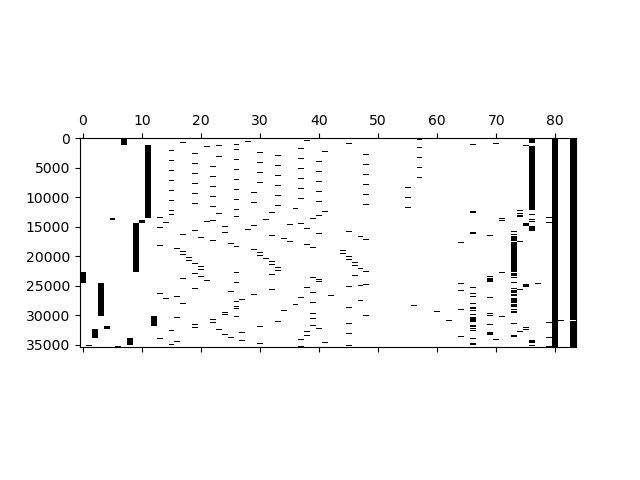

In [77]:
%matplotlib widget
plt.spy(simple_matrix_X,aspect=0.001)


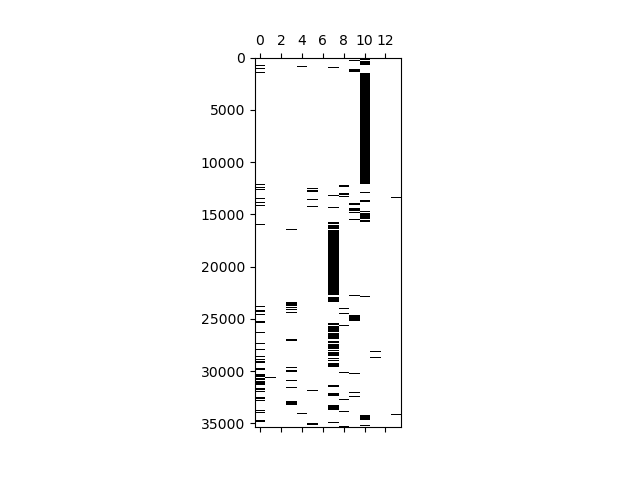

In [78]:

%matplotlib widget
plt.spy(simple_matrix_y,aspect=0.001)

In [79]:
module_new_X=[
   [
           z for z in x[0].toarray()[0]
        ]
     for x in all_t_X ]

In [83]:
module_new_y=[
   [
           z for z in x[0].toarray()[0]
        ]
     for x in all_t_y ]

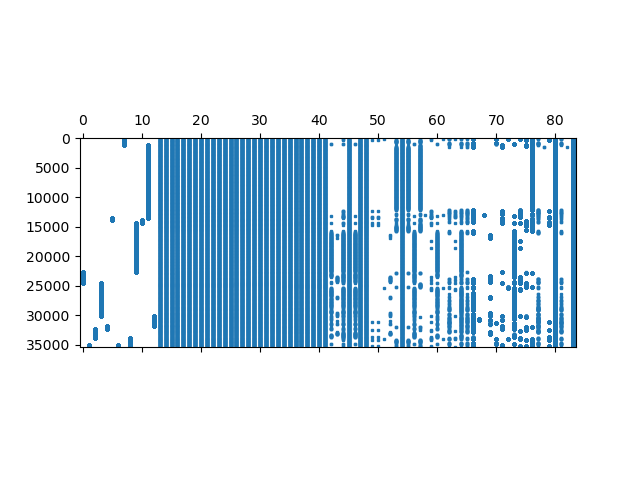

In [87]:
%matplotlib widget
plt.spy(module_new_X, precision = 0.1, markersize = 2, aspect=0.001)

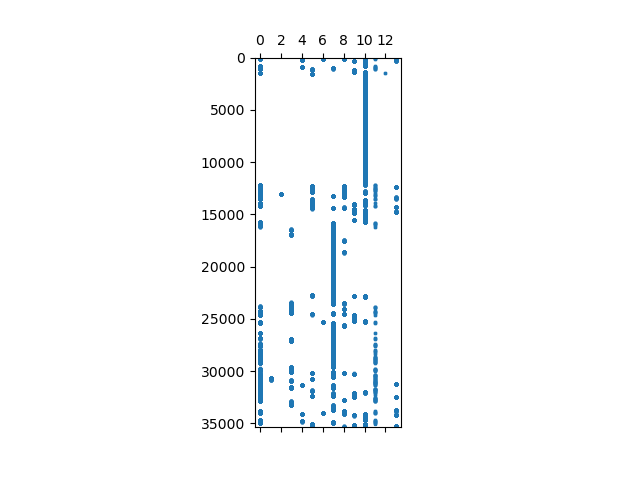

In [86]:
%matplotlib widget
plt.spy(module_new_y[:], precision = 0.1, markersize = 2, aspect=0.001)

In [88]:
# the count of true for column 0
len([y for y in list(enumerate([x[0] for x in module_new_X])) if y[1]==1])

1806

In [91]:
columns_X =[c for c in enumerate([str(x) for x in oheall_X.get_feature_names_out()
                      ])
                      ]

In [92]:
objects_per_column_X= { c[1] : len([y for y in list(enumerate([x[c[0]] for x in module_new])) if y[1]==1]) for c in columns_X}

In [93]:
objects_per_column_X

{'module_ast': 1806,
 'module_asttokens': 106,
 'module_codecs': 1530,
 'module_inspect': 5638,
 'module_json': 515,
 'module_keras': 356,
 'module_np': 247,
 'module_pandas': 1122,
 'module_pd': 1122,
 'module_plt': 8336,
 'module_sklearn': 458,
 'module_tensorflow': 12471,
 'module_types': 1654,
 'field___class__': 4218,
 'field___delattr__': 78,
 'field___dict__': 36,
 'field___dir__': 1634,
 'field___doc__': 181,
 'field___eq__': 748,
 'field___format__': 114,
 'field___ge__': 11700,
 'field___getattribute__': 936,
 'field___gt__': 1632,
 'field___hash__': 13392,
 'field___init__': 246,
 'field___init_subclass__': 2,
 'field___le__': 444,
 'field___lt__': 958,
 'field___match_args__': 958,
 'field___module__': 958,
 'field___ne__': 958,
 'field___new__': 958,
 'field___reduce__': 958,
 'field___reduce_ex__': 958,
 'field___repr__': 958,
 'field___setattr__': 958,
 'field___sizeof__': 958,
 'field___str__': 958,
 'field___subclasshook__': 958,
 'field___weakref__': 958,
 'field__att

In [94]:
objects_per_column_same_as_col_X= {c2[1] :[ 
    { 
        c[1] : len([y for y in list(enumerate([ x[c[0]] for x in module_new_X  
                                                                                                     if (x[c2[0]] ==1
                                                                                                        
                                                                                                        
                                                                                                        )
                                                                                                    ]
                                                                                                   )) if (y[1]==1 )
                                                                         
                                                                         ]) for c in 
         [cn for cn in columns_X if typeoffunction(c2[1]) != typeoffunction(cn[1])]
        
    } 
    ] for c2 in [cn for cn in columns_X ]
    }# object

KeyboardInterrupt: 

In [ ]:
objects_per_column_same_as_col_X

In [95]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
tv = sel.fit_transform(all_t_y)

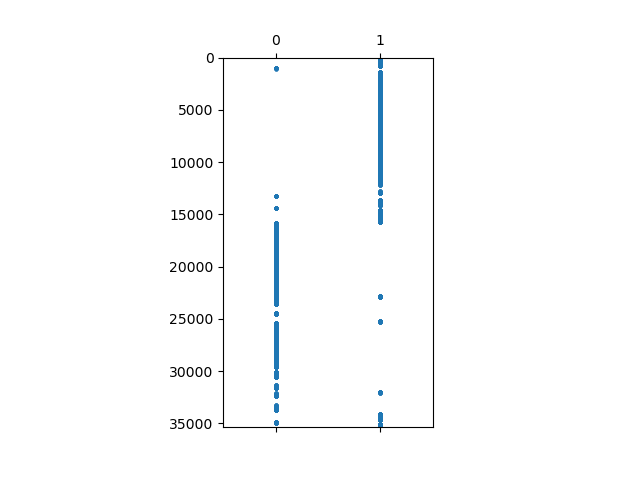

In [96]:
%matplotlib widget
plt.spy(tv, precision = 0.1, markersize = 2, aspect=0.0001)

In [ ]:
from sklearn.feature_selection import VarianceThreshold



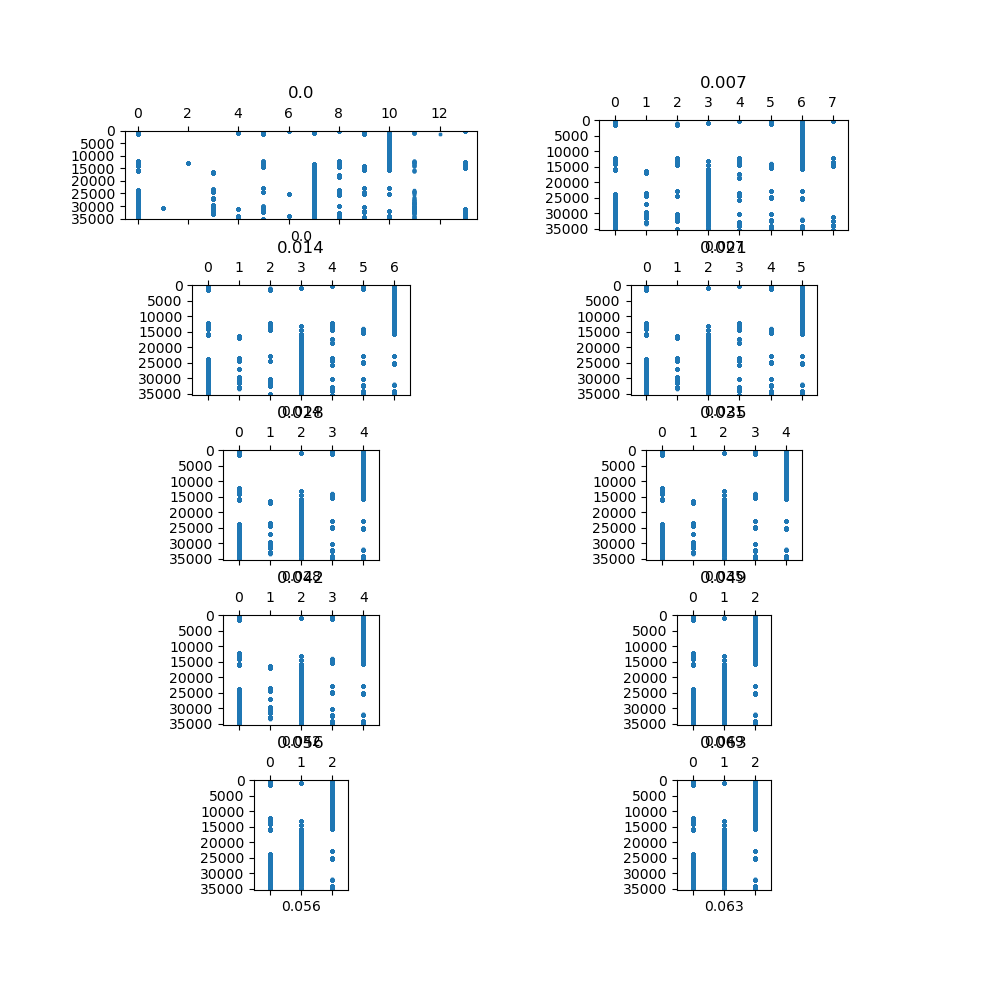

In [116]:
# define subplot grid
maxv = 10
fig, axs = plt.subplots(nrows=int(maxv/2), ncols=2, figsize=(10,10))
plt.subplots_adjust(hspace=0.5)

def generate_variance(max):
    for x in range(0,max):
        try:
            tt= x*0.007
            sel = VarianceThreshold(threshold=tt)
            tv = sel.fit_transform(all_t_y)
            yield (tt,tv)
        except :
            pass    
for tv, ax in zip(generate_variance(maxv), axs.ravel()):    
    ax.set_title(str(tv[0]))
    ax.set_xlabel(str(tv[0]))
    ax.spy(tv[1], precision = 0.1, markersize = 2, aspect=0.0001)
plt.show()

In [ ]:
# define subplot grid
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Daily closing prices", fontsize=18, y=0.95)

# loop through tickers and axes
for ticker, ax in zip(tickers, axs.ravel()):
    # filter df for ticker and plot on specified axes
    df[df["ticker"] == ticker].plot(ax=ax)

    # chart formatting
    ax.set_title(ticker.upper())
    ax.get_legend().remove()
    ax.set_xlabel("")

plt.show()

In [ ]:
import numpy as np

from sklearn.svm import LinearSVC


class NaivelyCalibratedLinearSVC(LinearSVC):
    """LinearSVC with `predict_proba` method that naively scales
    `decision_function` output."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max scale output of `decision_function` to [0,1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba
from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
svc = NaivelyCalibratedLinearSVC(C=1.0)
rfc = RandomForestClassifier()

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (svc, "SVC"),
    (rfc, "Random forest"),
]
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()